## BBC Experiment [Part 6 - Multi Task fastai Data Loader]

- ok, I think this is the last piece of the puzzle. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
path=Path('../data/bbc_train')

In [5]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/masks')]

In [6]:
fnames = get_image_files(path/'images')
fnames[:3]

[PosixPath('../data/bbc_train/images/P2050886.jpg'),
 PosixPath('../data/bbc_train/images/P2050729.jpg'),
 PosixPath('../data/bbc_train/images/P2050513.jpg')]

In [7]:
lbl_names = get_image_files(path/'masks')
lbl_names[:3]

[PosixPath('../data/bbc_train/masks/P2050393.png'),
 PosixPath('../data/bbc_train/masks/P2050807.png'),
 PosixPath('../data/bbc_train/masks/P2050940.png')]

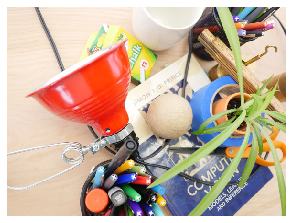

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
def get_y_fn(x): return path/'masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

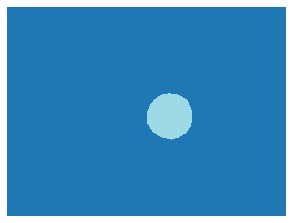

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
unique(mask.data)

array([0, 2])

In [12]:
src = (SegmentationItemList.from_folder(path/'images')
       .split_by_rand_pct(0.0)
       .label_from_func(get_y_fn, classes=classes))

In [13]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [14]:
data

ImageDataBunch;

Train: LabelList (942 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/images;

Valid: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: ../data/bbc_train/images;

Test: None

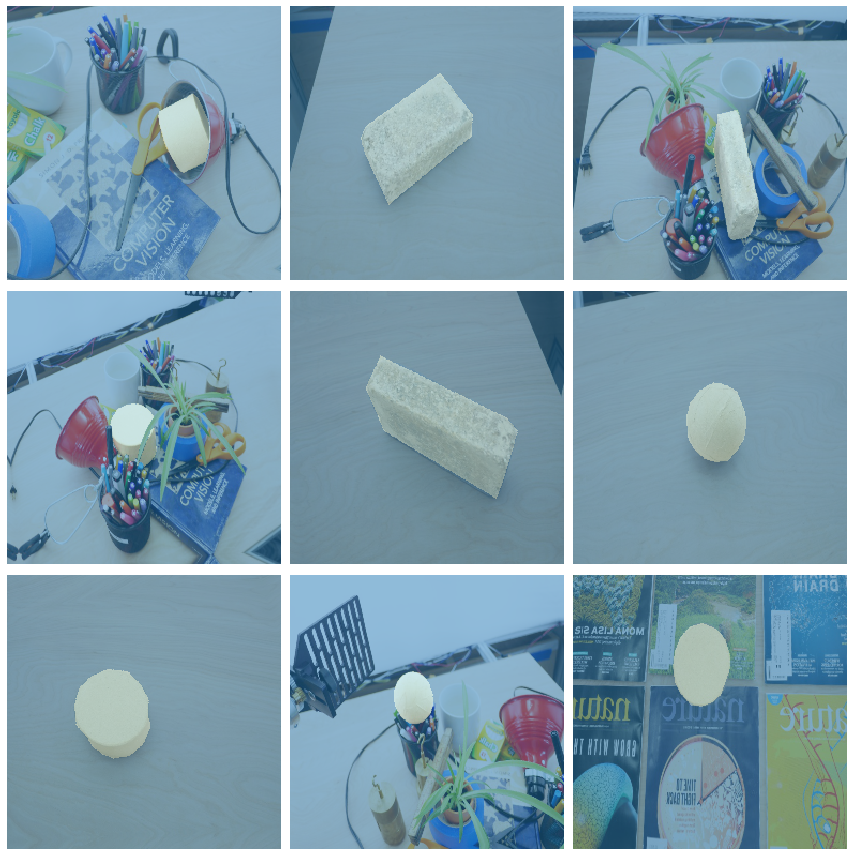

In [15]:
data.show_batch(3, figsize=(12,12))

In [16]:
x,y = data.one_batch()

In [17]:
x.shape, x.dtype, y.shape, y.dtype

(torch.Size([16, 3, 256, 256]),
 torch.float32,
 torch.Size([16, 1, 256, 256]),
 torch.int64)

In [18]:
np.unique(y)

array([0, 1, 2, 3])

In [24]:
#Extract class label from mask:
class_labels=np.array([np.unique(y[i][y[i]!=0])[0] for i in range(x.shape[0])])

#Extract bounding box from mask:
bboxes=np.zeros((x.shape[0], 4))
for i in range(x.shape[0]):
    rows,cols= np.where(y[i, 0]!=0)
    bboxes[i, :] = np.array([rows.min(), cols.min(), rows.max(), cols.max()])

In [25]:
def blend_image_mask(im, mask, alpha=0.7):
    im_mask=np.zeros((im.shape[1], im.shape[2], 3), dtype='float32')
    for j in range(3): im_mask[:,:,j]=im.mean(axis=0)
    for j in range(1, 4):
        im_mask[mask==j] = alpha*im_mask[mask==j] + (1-alpha)*np.array([float(i==(j-1)) for i in range(3)])
    return im_mask

In [26]:
def corners_from_bbox(bbox):
    return np.array([[bbox[1], bbox[0]], 
                  [bbox[3], bbox[0]],
                  [bbox[3], bbox[2]],
                  [bbox[1], bbox[2]],
                  [bbox[1], bbox[0]]])

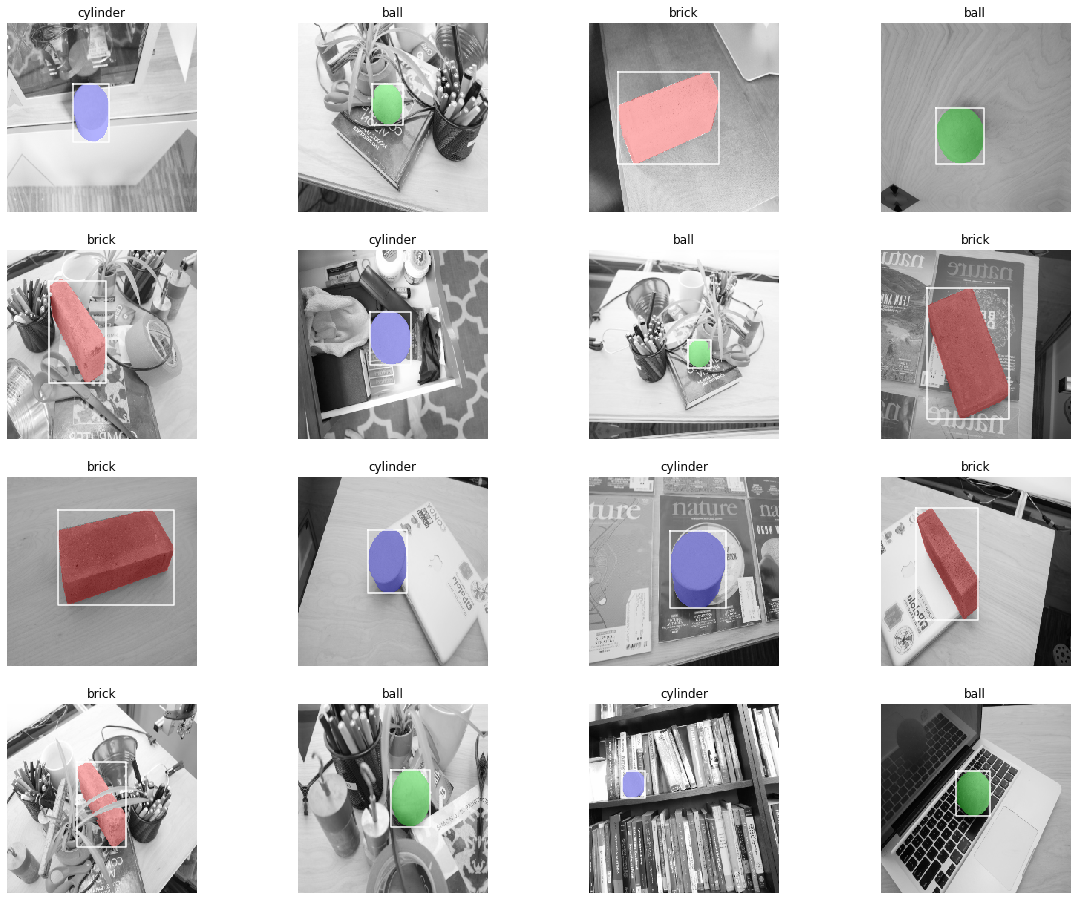

In [27]:
fig = figure(0, (20, 16))

for i in range(16):
    fig.add_subplot(4,4,i+1)
    im_mask=blend_image_mask(x[i], y[i, 0])
    corners=corners_from_bbox(bboxes[i, :])
    
    imshow(im_mask, cmap='gray'); axis('off')
    plot(corners[:, 0], corners[:,1], c=(1, 1, 1))
    title(data.classes[class_labels[i]])

- This would look cool in a video!!
- Ok, let's think about how we're going to measure performance in the evaluation script!

In [28]:
class_labels

array([3, 2, 1, 2, 1, 3, 2, 1, 1, 3, 3, 1, 1, 2, 3, 2])

In [29]:
class_names=['brick', 'ball', 'cylinder']

In [30]:
class_predictions=[class_names[np.random.randint(3)] for i in range(x.shape[0])]

#Scale randomly chosen bbox coords to image shape:
bbox=np.random.rand(x.shape[0], 4)
bbox[:,0] *= x.shape[2]; bbox[:,2] *= x.shape[2] 
bbox[:,1] *= x.shape[3]; bbox[:,3] *= x.shape[3]

#Create random segmentation mask:
mask=np.random.randint(low=0, high=4, size=(x.shape[0], x.shape[2], x.shape[3]))

preds=(class_predictions, bbox, mask)

In [31]:
preds[0]

['ball',
 'cylinder',
 'ball',
 'brick',
 'ball',
 'ball',
 'ball',
 'cylinder',
 'brick',
 'cylinder',
 'ball',
 'cylinder',
 'brick',
 'cylinder',
 'cylinder',
 'brick']

In [38]:
classification_accuracy=(np.array([data.classes[i] for i in class_labels])==np.array(preds[0])).sum()/len(preds[0])
bbox_score = 1 - np.mean(np.abs(bboxes-preds[1]))/(x.shape[-1]) #Divide by image height to rougly normalize score
segmentation_accuracy=float((preds[2] == np.array(y.squeeze(1))).sum())/y.numel()

In [39]:
score=np.mean([classification_accuracy, bbox_score, segmentation_accuracy])

In [40]:
classification_accuracy, bbox_score, segmentation_accuracy, score

(0.3125, 0.7044299653168316, 0.2503623962402344, 0.42243078718568866)

In [48]:
torch.cuda.current_device()

0

In [47]:
import fastai, torch
print(fastai.__version__, torch.__version__)

1.0.57 1.2.0


In [178]:
y.shape

torch.Size([16, 1, 256, 256])

In [173]:
classification_accuracy, bbox_score

(0.4375, 0.7437573289082388)

0.25624267109176124

In [171]:
x.shape

torch.Size([16, 3, 256, 256])

In [118]:
data.classes[class_labels[i]]

'cylinder'

In [102]:
bbox

array([ 68,  98, 166, 167])

In [48]:
i=5
class_index=np.unique(y[i][y[i]!=0])[0]

In [52]:
y[i].shape

torch.Size([1, 256, 256])

In [67]:
rows, cols = np.where(y[i, 0]!=0)
bbox = np.array([rows.min(), cols.min(), rows.max(), cols.max()])

In [68]:
corners=np.array([[bbox[1], bbox[0]], 
                  [bbox[3], bbox[0]],
                  [bbox[3], bbox[2]],
                  [bbox[1], bbox[2]],
                  [bbox[1], bbox[0]]])

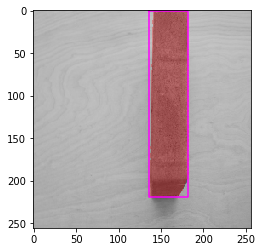

In [84]:
im_mask=blend_image_mask(x[i], y[i, 0])
imshow(im_mask, cmap='gray')
plot(corners[:, 0], corners[:,1], c=(1, 0, 1))